# Analysis using data with similar number of binary variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, kendalltau, zscore
from cliffs_delta import cliffs_delta
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="Greys")

In [2]:
data = pd.read_csv("../data/bias_symptoms_raw.csv", index_col=[0,1])

In [3]:
def remove_outliers(data):
  data_new = data.reset_index()
  high_data = data_new.groupby("data").count()
  high_data[high_data['variable'] < high_data['variable'].quantile(0.75)]
  data_new = data_new[data_new["data"].isin(high_data[high_data["variable"] < high_data["variable"].quantile(0.75)].index)]
  data_new.drop(columns=["data", "variable"], inplace=True)
  sp = data_new.pop("statistical_parity")
  eo = data_new.pop("equal_opportunity")
  ao = data_new.pop("average_odds")

  data_new.insert(len(data_new.columns), "statistical_parity", sp)
  data_new.insert(len(data_new.columns), "equal_opportunity", eo)
  data_new.insert(len(data_new.columns), "average_odds", ao)
  return data_new

In [5]:
data.groupby(data.index.get_level_values(1)).count()

,correlation_true,mutual_info,unpriv_prob_pos,priv_prob_pos,unpriv_unbalance,priv_unbalance,statistical_parity,equal_opportunity,average_odds,kurtosis_var,skew_var,gini,simpson,shannon,ir,pos_prob
data,,,,,,,,,,,,,,,,
adult,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902,902
arrhythmia,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318,318
bank,440,440,440,440,440,440,440,440,440,440,440,440,440,440,440,440
cmc,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
compas,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371,1371
credit,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
crime,21,21,21,21,21,21,21,20,21,21,21,21,21,21,21,21
diabetic,709,709,709,709,709,709,709,709,709,709,709,709,709,709,709,709
drug,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


## Correlation Analysis

In [252]:
data_new = remove_outliers(data)
kendall = data_new.corr("kendall").round(3)

def highlight_cols(kendall):
    if type(kendall) != str and np.abs(kendall) > 0.4:
        return "background-color: green"
    return ""

for col in kendall.columns:
    for col2 in kendall.columns:
        pval = kendalltau(data[col], data[col2])[1]
        if pval > 0.05:
            kendall.loc[col, col2] = f"{kendall.loc[col, col2]}*"

kendall.style.applymap(highlight_cols)

,correlation_true,mutual_info,unpriv_prob_pos,priv_prob_pos,unpriv_unbalance,priv_unbalance,kurtosis_var,skew_var,gini,simpson,shannon,ir,pos_prob,statistical_parity,equal_opportunity,average_odds
correlation_true,1.000000,0.042*,0.014000,0.020000,-0.099000,0.100000,-0.009*,-0.036*,-0.029*,0.034000,0.035000,0.006*,0.076000,-0.244000,-0.321000,-0.028*
mutual_info,0.042*,1.000000,-0.023000,-0.073000,0.079000,-0.039*,-0.105000,-0.125000,-0.112000,0.105000,0.100000,0.110000,0.586000,0.054000,-0.019000,0.041000
unpriv_prob_pos,0.014000,-0.023000,1.000000,0.492000,0.189000,-0.091*,-0.135000,-0.113000,-0.077000,0.327000,0.331000,0.131000,0.088000,0.104000,-0.056000,0.006000
priv_prob_pos,0.020000,-0.073000,0.492000,1.000000,-0.262000,0.378000,-0.095000,-0.081000,-0.081000,0.322000,0.328000,0.093000,0.093000,-0.222000,0.132000,-0.024000
unpriv_unbalance,-0.099000,0.079000,0.189000,-0.262000,1.000000,-0.589000,-0.064000,-0.074*,-0.035*,0.021000,0.020000,0.065000,-0.002*,0.542000,-0.136000,0.154000
priv_unbalance,0.100000,-0.039*,-0.091*,0.378000,-0.589000,1.000000,0.052000,0.044000,0.039000,0.018000,0.019000,-0.050000,0.007000,-0.475000,0.125000,-0.097000
kurtosis_var,-0.009*,-0.105000,-0.135000,-0.095000,-0.064000,0.052000,1.000000,0.608000,0.568000,-0.373000,-0.362000,-0.954000,0.042000,-0.044000,0.004000,0.089000
skew_var,-0.036*,-0.125000,-0.113000,-0.081000,-0.074*,0.044000,0.608000,1.000000,0.947000,-0.334000,-0.328000,-0.612000,-0.025000,-0.077000,0.012000,0.113000
gini,-0.029*,-0.112000,-0.077000,-0.081000,-0.035*,0.039000,0.568000,0.947000,1.000000,-0.315000,-0.309000,-0.580000,-0.058000,-0.041000,0.012000,0.147000
simpson,0.034000,0.105000,0.327000,0.322000,0.021000,0.018000,-0.373000,-0.334000,-0.315000,1.000000,0.988000,0.361000,0.184000,0.011000,-0.007000,-0.013000


## Distribution of the data

In [253]:
data.shape

(5930, 16)

In [254]:
data = pd.read_csv("../data/bias_symptoms.csv", index_col=[0, 1])
data = remove_outliers(data)

In [255]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=4, aspect=1)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[1:4:2],
    )
    g.set_titles("{col_name}")
    g.add_legend()
    # g.facet_axis(0,0).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False)[1]))
    # g.facet_axis(0,1).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False)[1]))
    # g.facet_axis(0,2).set_xlabel("T test pvalue: "+str(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False)[1]))
    g.set_axis_labels("", symp_name)
    # plt.savefig(f"figs/{symp_name}.pdf", bbox_inches="tight")
    # plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))
    print(cliffs_delta(corr_high_sp, corr_low_sp))
    print(cliffs_delta(corr_high_eo, corr_low_eo))
    print(cliffs_delta(corr_high_ao, corr_low_ao))
    return g

### Analysis of Mutual Information

TtestResult(statistic=10.856533112251517, pvalue=1.0708888103569397e-24, df=478.7187603289741)
TtestResult(statistic=7.065967760207554, pvalue=9.094909876855293e-12, df=339.620816802453)
TtestResult(statistic=6.832097726075935, pvalue=2.2253551826220012e-11, df=549.9669661652812)
(0.5733352499945096, 'large')
(0.5286335349160785, 'large')
(0.38561263338202256, 'medium')


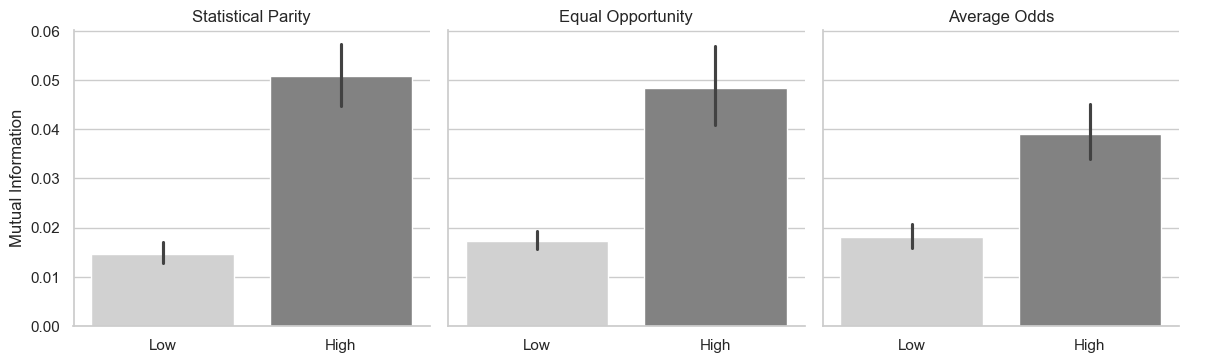

In [256]:
g = plot_differences(data, "mutual_info", "Mutual Information")
plt.show()

## Kendall's Tau

TtestResult(statistic=3.8542678525346203, pvalue=0.00013242267231034389, df=464.30647687396817)
TtestResult(statistic=1.3878867344059445, pvalue=0.1660401671902938, df=355.7409500245069)
TtestResult(statistic=0.5624840736382716, pvalue=0.5740234005032772, df=531.5157525207454)
(0.16582313609691918, 'small')
(0.06716575610149893, 'negligible')
(-0.029559626676991125, 'negligible')


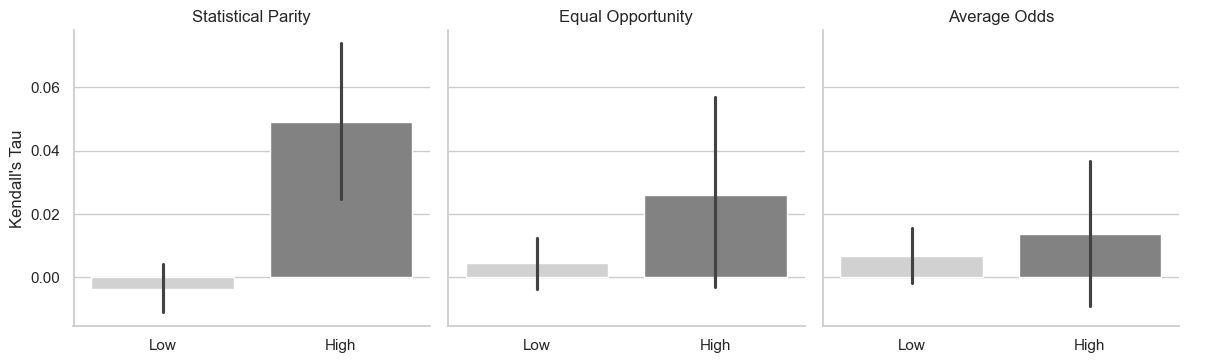

In [257]:
g = plot_differences(data, "correlation_true", "Kendall's Tau")
plt.show()

## Feature Importance

In [258]:
from sklearn.inspection import permutation_importance
import numpy as np
from scipy.stats import mannwhitneyu
from joblib import load

In [259]:
labels = ["statistical_parity", "equal_opportunity", "average_odds"]
mlp = load("../ml_models/bias_symptoms_mlp.joblib")
rf = load("../ml_models/bias_symptoms_rf.joblib")
xgb = load("../ml_models/bias_symptoms_xgb.joblib")

In [260]:
def train_model(metric):
    mlp.fit(data.drop(columns=labels), data[metric])
    rf.fit(data.drop(columns=labels), data[metric])
    xgb.fit(data.drop(columns=labels), data[metric])
    return mlp, rf, xgb

In [261]:
def plot_importance(result):
    sorted_importances_idx = result['importances_mean'].argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=data.drop(columns=labels).columns[sorted_importances_idx],
    )
    fig, ax = plt.subplots(figsize=(2, 4))
    ax = importances.plot.box(vert=False, whis=10, color="black", ax=ax)
    #ax.axvline(x=0, color="k", linestyle="--")
    # ax.axhline(y=8.5, color="k", linestyle="--")
    ax.set_xlabel("AP Loss")
    return ax

def compute_statistical_difference(result):
    sorted_importances_idx = result["importances_mean"].argsort()
    importances = result.importances[sorted_importances_idx].T
    ris = []
    for i in range(importances.shape[1]):
        find = False
        for j in range(i + 1, importances.shape[1]):
                if not find:
                    test = mannwhitneyu(importances[:, i], importances[:, j])
                    if test[1] < 0.05:
                        print(
                            i+1, j+1,
                            # result["importances_mean"].index[sorted_importances_idx[i]],
                            # result["importances_mean"].index[sorted_importances_idx[j]],
                        )
                        find = True
                        ris.append((i+1, j+1))
    return ris

def compute_permutation(metric, xgb, rf, mlp):
    result_xgb = permutation_importance(
        xgb,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    result_rf = permutation_importance(
        rf,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    result_mlp = permutation_importance(
        mlp,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    return result_xgb, result_rf, result_mlp

### Statistical Parity

In [262]:
mlp_sp, rf_sp, xgb_sp = train_model('statistical_parity')

In [263]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation('statistical_parity', xgb_sp, rf_sp, mlp_sp)

In [264]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 3
3 5
4 5
5 7
6 8
7 8
8 9
9 11
10 11
11 12
12 13


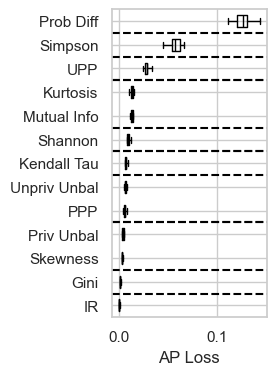

In [265]:
ax_xgb = plot_importance(result_xgb_sp)
tick_labels = [
        "Prob Diff",
        "Simpson",
        "UPP",
        "Kurtosis",
        "Mutual Info",
        "Shannon",
        "Kendall Tau",
        "Unpriv Unbal",
        "PPP",
        "Priv Unbal",
        "Skewness",
        "Gini",
        "IR",
    ]
tick_labels.reverse()
ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")

In [266]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 3
3 5
4 5
5 6
6 8
7 8
8 10
9 10
10 11
11 12
12 13


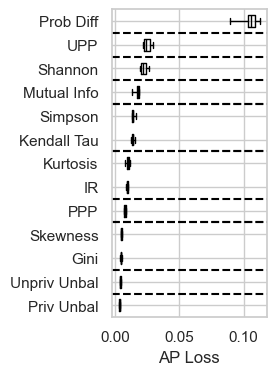

In [267]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Prob Diff",
    "UPP",
    "Shannon",
    "Mutual Info",
    "Simpson",
    "Kendall Tau",
    "Kurtosis",
    "IR",
    "PPP",
    "Skewness",
    "Gini",
    "Unpriv Unbal",
    "Priv Unbal",
]
tick_labels.reverse()
ax_rf.set_yticklabels(tick_labels)
plt.show()

In [268]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 3
3 6
4 6
5 6
6 7
7 9
8 9
9 11
10 11
11 12
12 13


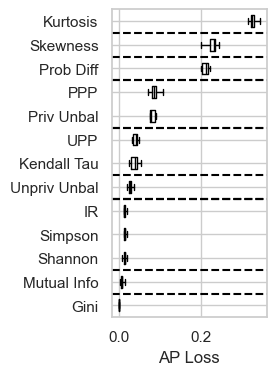

In [269]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Kurtosis",
    "Skewness",
    "Prob Diff",
    "PPP",
    "Priv Unbal",
    "UPP",
    "Kendall Tau",
    "Unpriv Unbal",
    "IR",
    "Simpson",
    "Shannon",
    "Mutual Info",
    "Gini",
]
tick_labels.reverse()
ax_mlp.set_yticklabels(tick_labels)
plt.show()

## Equal Opportunity

In [270]:
mlp_eo, rf_eo, xgb_eo = train_model("equal_opportunity")

In [271]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation(
    "equal_opportunity", xgb_sp, rf_sp, mlp_sp
)

In [272]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 3
3 4
4 5
5 7
6 7
7 9
8 9
9 10
10 11
11 12
12 13


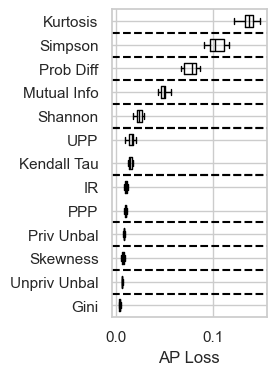

In [273]:
ax_xgb = plot_importance(result_xgb_sp)
tick_labels = [
        "Kurtosis",
        "Simpson",
        "Prob Diff",
        "Mutual Info",
        "Shannon",
        "UPP",
        "Kendall Tau",
        "IR",
        "PPP",
        "Priv Unbal",
        "Skewness",
        "Unpriv Unbal",
        "Gini",
    ]
tick_labels.reverse()
ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")
plt.show()

In [274]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 4
3 4
4 6
5 6
6 7
7 8
8 9
9 11
10 11
11 12
12 13


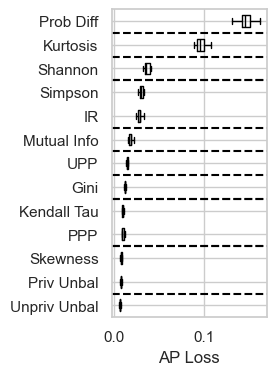

In [275]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Prob Diff",
    "Kurtosis",
    "Shannon",
    "Simpson",
    "IR",
    "Mutual Info",
    "UPP",
    "Gini",
    "Kendall Tau",
    "PPP",
    "Skewness",
    "Priv Unbal",
    "Unpriv Unbal",
]
tick_labels.reverse()
ax_rf.set_yticklabels(tick_labels)
plt.show()

In [276]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 3
2 3
3 5
4 5
5 6
6 8
7 8
8 9
9 10
10 12
11 12
12 13


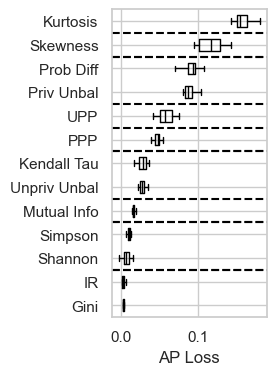

In [277]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Kurtosis",
    "Skewness",
    "Prob Diff",
    "Priv Unbal",
    "UPP",
    "PPP",
    "Kendall Tau",
    "Unpriv Unbal",
    "Mutual Info",
    "Simpson",
    "Shannon",
    "IR",
    "Gini",
]
tick_labels.reverse()
ax_mlp.set_yticklabels(tick_labels)
plt.show()

## Average Odds

In [278]:
mlp_ao, rf_ao, xgb_ao = train_model("average_odds")

In [279]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation(
    "average_odds", xgb_sp, rf_sp, mlp_sp
)

In [280]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 3
3 5
4 6
5 6
6 7
7 8
8 9
9 10
10 12
11 12
12 13


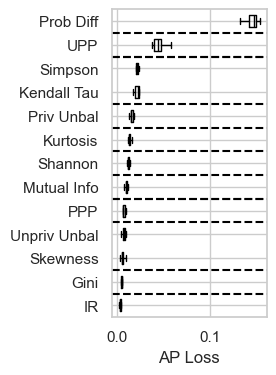

In [281]:
ax_xgb = plot_importance(result_xgb_sp)
tick_labels = [
        "Prob Diff",
        "UPP",
        "Simpson",
        "Kendall Tau",
        "Priv Unbal",
        "Kurtosis",
        "Shannon",
        "Mutual Info",
        "PPP",
        "Unpriv Unbal",
        "Skewness",
        "Gini",
        "IR",
    ]
tick_labels.reverse()
ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")
ax_xgb.set_yticklabels(tick_labels)

plt.show()

In [282]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 4
3 4
4 7
5 7
6 8
7 8
8 9
9 10
10 11
11 12
12 13


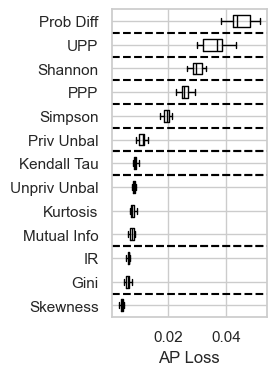

In [283]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Prob Diff",
    "UPP",
    "Shannon",
    "PPP",
    "Simpson",
    "Priv Unbal",
    "Kendall Tau",
    "Unpriv Unbal",
    "Kurtosis",
    "Mutual Info",
    "IR",
    "Gini",
    "Skewness",
]
tick_labels.reverse()
ax_rf.set_yticklabels(tick_labels)
plt.show()

In [284]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 3
3 4
4 6
5 6
6 8
7 8
8 10
9 10
10 12
11 12
12 13


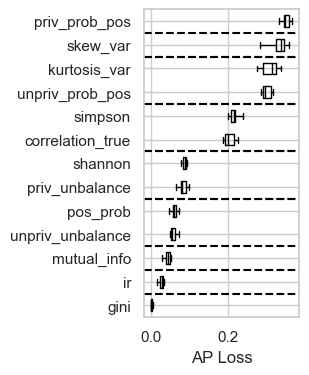

In [285]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Skewness",
    "Kurtosis",
    "Priv Unbal",
    "PPP",
    "UPP",
    "Prob Diff",
    "Unpriv Unbal",
    "Kendall Tau",
    "Shannon",
    "Simpson",
    "IR",
    "Mutual Info",
    "Gini",
]
tick_labels.reverse()
# ax_mlp.set_yticklabels(tick_labels)
plt.show()